In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import snapatac2 as snap
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import pyranges as pr
import os
import warnings
import requests
# plt.rcdefaults()

import sys
sys.path.append('/scratch/eli')
from perturbseq import *

### 1b) Assignment comparison between SIRLOIN/TSO and no-SIRLOIN vectors with T7 guide library prep

In [2]:
def prep_assignment_dataset(guide_call_summary, sample_id, library_id):

    df = pd.read_csv(guide_call_summary, index_col = 0).query(f"sample == '{sample_id}'")
    df['calls'] = df.n_guides.map(lambda n: '3+' if n in ['3','4+'] else str(n))
    df.rename({'pct_cells': 'pct_nuclei', 'count': 'n_cells'}, axis = 1, inplace = True)
    df = df[['calls', 'n_cells', 'pct_nuclei']].groupby('calls').sum().reset_index()
    df['library'] = library_id

    return df[['calls', 'n_cells', 'library', 'pct_nuclei']]

In [17]:
sirloinTSO_multiome_assignment = prep_assignment_dataset("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/T7_downsampled/240630_T7_downsampled_guide_call_summary.csv", sample_id = "Lane1_040", library_id = "+SIRLOIN/TSO\nT7")
nosirloin_multiome_assignment = prep_assignment_dataset("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/T7_downsampled/240630_T7_downsampled_guide_call_summary.csv", sample_id = "Lane2_047", library_id = "-SIRLOIN/TSO\nT7")
sirloinTSO_crop_assignment = prep_assignment_dataset("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/CROPseq_downsampled/240630_CROPseq_downsampled_guide_call_summary.csv", sample_id = "Lane1_040", library_id='+SIRLOIN/TSO\nCROPseq')
nosirloin_crop_assignment = prep_assignment_dataset("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/CROPseq_downsampled/240630_CROPseq_downsampled_guide_call_summary.csv", sample_id = "Lane2_047", library_id='-SIRLOIN/TSO\nCROPseq')
final_T7 = prep_assignment_dataset("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/T7_outs/240428_run2_guide_call_summary.csv", sample_id = "Lane1_040", library_id='+SIRLOIN/TSO\nT7 ')

In [18]:
df = pd.concat([sirloinTSO_multiome_assignment, nosirloin_multiome_assignment, sirloinTSO_crop_assignment, nosirloin_crop_assignment, final_T7], axis = 0).query("calls != '0'")
df['library'] = pd.Categorical(df.library, categories = ['-SIRLOIN/TSO\nCROPseq', '+SIRLOIN/TSO\nCROPseq', '-SIRLOIN/TSO\nT7', '+SIRLOIN/TSO\nT7', '+SIRLOIN/TSO\nT7 '], ordered = True)
df['calls'] = pd.Categorical(df.calls, categories = ['3+', '2', '1'], ordered = True)

/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 5.5 in image.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: outs/figs_v1/fig1b_assignment_DOWNSAMPLED_resized.pdf
2024-07-02 18:59:52 - INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


2024-07-02 18:59:52 - INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


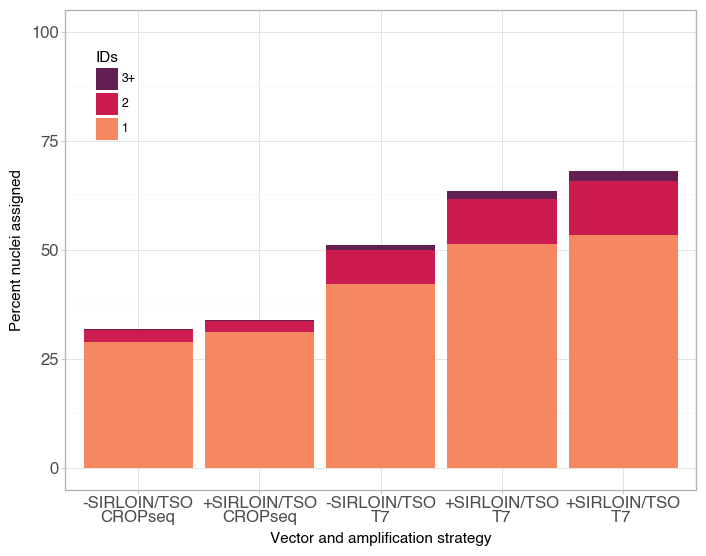

In [27]:
p = (
    ggplot(df)
        + geom_col(aes(x = 'library', y = 'pct_nuclei', fill = 'calls'))
        + theme_light()
        + theme(text=element_text(family="Helvetica"))
        + theme(axis_text_x=element_text(size=12),  # Set X-axis label font size
                axis_text_y=element_text(size=12))
        # + theme(axis_text_x=element_text(rotation=30, hjust=1))
        + theme(figure_size=(7, 5.5))
        + theme(legend_position = (0.05,0.9))
        + ylim(0,100)
        + scale_fill_manual(sns.color_palette("rocket", 3).as_hex())
        + labs(alpha = 'Chemistry', x = 'Vector and amplification strategy', y = 'Percent nuclei assigned', fill = 'IDs')
)
p.save("outs/figs_v1/fig1b_assignment_DOWNSAMPLED_resized.pdf", dpi = 300)
p.draw()

### 1c) Density of UMI and total reads of CROPseq transcripts with cell-associated barcodes (as called by cellranger, no additional filtering)

In [28]:
def get_dual_reads(reads_file):
    raw_reads = pd.read_csv(reads_file, index_col=[0,1,2])
    return raw_reads

def get_identity_stats_new(raw_reads):
    
    identities = raw_reads.groupby(level=[0, 2])[['count']].count()
    identities.columns = ['UMI']
    identities['total_reads'] = raw_reads.groupby(level=[0, 2])['count'].sum()
    
    return identities

In [29]:
df_sirloin = get_identity_stats_new(get_dual_reads("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/T7_downsampled/Lane1_040_filtered_barcode_umis.csv.gz"))
df_sirloin["UMI"] = np.log2(df_sirloin["UMI"])
df_sirloin["total_reads"] = np.log2(df_sirloin['total_reads'])

In [30]:
df_t7 = get_identity_stats_new(get_dual_reads("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/T7_downsampled/Lane2_047_filtered_barcode_umis.csv.gz"))
df_t7["UMI"] = np.log2(df_t7["UMI"])
df_t7["total_reads"] = np.log2(df_t7['total_reads'])

In [31]:
df_sirloin_crop = get_identity_stats_new(get_dual_reads("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/CROPseq_downsampled/Lane1_040_filtered_barcode_umis.csv.gz"))
df_sirloin_crop["UMI"] = np.log2(df_sirloin_crop["UMI"])
df_sirloin_crop["total_reads"] = np.log2(df_sirloin_crop['total_reads'])

In [32]:
df_crop = get_identity_stats_new(get_dual_reads("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/CROPseq_downsampled/Lane2_047_filtered_barcode_umis.csv.gz"))
df_crop["UMI"] = np.log2(df_crop["UMI"])
df_crop["total_reads"] = np.log2(df_crop['total_reads'])

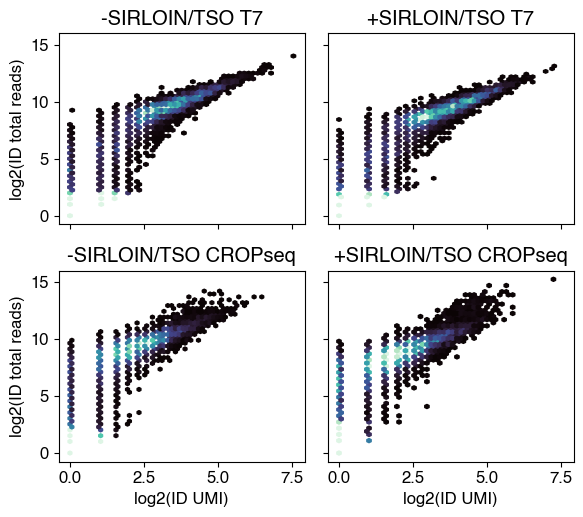

In [35]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize = (6,5.33), nrows = 2, ncols = 2, sharey = True, sharex = True)
ax[0,0].hexbin(x = df_t7["UMI"], y = df_t7["total_reads"], cmap = 'mako', vmax = 100, gridsize = 50, mincnt = 1)
# ax[0,0].set_xlabel("log2(sgRNA UMI)")
ax[0,0].set_ylabel("log2(ID total reads)")
ax[0,0].set_title("-SIRLOIN/TSO T7")

ax[0,1].hexbin(x = df_sirloin["UMI"], y = df_sirloin["total_reads"], cmap = 'mako', vmax = 100, gridsize = 50, mincnt = 1)
# ax[0,1].set_xlabel("log2(sgRNA UMI)")
ax[0,1].set_title("+SIRLOIN/TSO T7")

ax[1,0].hexbin(x = df_crop["UMI"], y = df_crop["total_reads"], cmap = 'mako', vmax = 100, gridsize = 50, mincnt = 1)
ax[1,0].set_xlabel("log2(ID UMI)")
ax[1,0].set_ylabel("log2(ID total reads)")
ax[1,0].set_title("-SIRLOIN/TSO CROPseq")

ax[1,1].hexbin(x = df_sirloin_crop["UMI"], y = df_sirloin_crop["total_reads"], cmap = 'mako', vmax = 100, gridsize = 50, mincnt = 1)
ax[1,1].set_xlabel("log2(ID UMI)")
ax[1,1].set_title("+SIRLOIN/TSO CROPseq")

plt.tight_layout()
plt.savefig("outs/figs_v1/fig1c_density_DOWNSAMPLED.pdf")
plt.show()

### 1d) On-target knockdown of gene expression and accessibility

The singlets for both lanes are filtered here, but we are only looking at Lane 1 (+SIRLOIN/TSO from this point on)

In [ ]:
adata = snap.pp.import_data(
    "/data/norman/eli/T7/202404_SIRLOIN_multiome/Lane1_040/outs/atac_fragments.tsv.gz",
    chrom_sizes = snap.genome.hg38,
    sorted_by_barcode = False
)
snap.metrics.tsse(adata, snap.genome.hg38)
snap.pp.add_tile_matrix(adata)
snap.pp.select_features(adata, n_features=250000)
adata.write("intermediate_files/Lane1_040_preprocessed_atac.h5ad")

In [ ]:
adata047 = snap.pp.import_data(
    "/data/norman/eli/T7/202404_SIRLOIN_multiome/Lane2_047/outs/atac_fragments.tsv.gz",
    chrom_sizes = snap.genome.hg38,
    sorted_by_barcode = False
)
snap.metrics.tsse(adata047, snap.genome.hg38)
snap.pp.add_tile_matrix(adata047)
snap.pp.select_features(adata047, n_features=250000)
adata047.write("intermediate_files/Lane2_047_preprocessed_atac.h5ad")

In [2]:
adata = snap.read("../intermediate_files/Lane1_040_preprocessed_atac.h5ad", backed = None)
adata047 = snap.read("../intermediate_files/Lane2_047_preprocessed_atac.h5ad", backed = None)

In [3]:
# relies on output of cropseq_call_guides_multiome.py and cellranger output

def cut_qc_metrics_by_called(sample_name, figsize = (15,5), mode = 'gex'):

    id_files = [file for file in os.scandir("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/T7_outs") if "called_ids" in file.name]
    called_ids = pd.read_csv([f for f in id_files if  sample_name in f.name][0]).reset_index().groupby("CB").UMI.count().to_frame("n_guides")
    called_ids.index = called_ids.index.map(lambda cb: cb + "-1")

    if mode == 'gex':

        adata_files = [file for file in os.scandir("/data/norman/eli/T7/202404_SIRLOIN_multiome/") if sample_name in file.name]
        adata_path = adata_files[0].path + '/outs/filtered_feature_bc_matrix.h5'

        adata = sc.read_10x_h5(adata_path)
        adata.var_names_make_unique()
        adata.var["mito"] = adata.var_names.str.startswith("MT-")
        sc.pp.calculate_qc_metrics(adata, inplace=True, qc_vars = ["mito"])
        
        merge = adata.obs.join(called_ids, how = 'left')
        merge["called"] = merge["n_guides"].fillna(0).map(lambda n: n > 0)
        merge.drop_duplicates(inplace = True)

        fig, ax = plt.subplots(1, 3, figsize=figsize)
        sns.histplot(data = merge, x = 'log1p_total_counts', kde = True, hue = 'called', ax = ax[0])
        sns.histplot(data = merge, x = 'log1p_n_genes_by_counts', kde = True, hue = 'called', ax = ax[1])
        sns.histplot(data = merge, x = 'pct_counts_mito', kde = True, hue = 'called', ax = ax[2])
        ax[2].set_xlim([-2,50])
        fig.suptitle(f"{sample_name} GEX QC metrics by guide call")
        fig.show()

    elif mode == 'atac':

        adata_files = [file for file in os.scandir("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/intermediate_files") if sample_name in file.name and 'preprocessed_atac' in file.name]
        adata = snap.read(adata_files[0].path, backed = None)
        merge = adata.obs.join(called_ids, how = 'left')
        merge["called"] = merge["n_guides"].fillna(0).map(lambda n: n > 0)
        merge.drop_duplicates(inplace = True)

        fig, ax = plt.subplots(1, 2, figsize=figsize)
        sns.histplot(data = merge, x = 'n_fragment', kde = True, hue = 'called', ax = ax[0])
        ax[0].set_xlim([0,1e5])
        sns.histplot(data = merge, x = 'tsse', kde = True, hue = 'called', ax = ax[1])
        fig.suptitle(f"{sample_name} ATAC QC metrics by guide call")
        fig.show()

    return merge

In [ ]:
gexqc_040 = cut_qc_metrics_by_called("Lane1_040")
atacqc_040 = cut_qc_metrics_by_called("Lane1_040", mode = 'atac')
qc040 = gexqc_040.join(atacqc_040.drop(["n_guides", "called"], axis = 1), how = 'inner')
qc040.n_fragment = qc040.n_fragment.astype(int)

In [5]:
singlets_040 = qc040.query("n_guides == 1 and log1p_total_counts > 6 and log1p_n_genes_by_counts > 6 and n_fragment > 1000")

In [6]:
print(len(singlets_040))
print(np.expm1(singlets_040.log1p_n_genes_by_counts).mean())
print(singlets_040.n_fragment.mean())

4724
2739.2461896697705
19202.398602878915


In [ ]:
gexqc_047 = cut_qc_metrics_by_called("Lane2_047")
atacqc_047 = cut_qc_metrics_by_called("Lane2", mode = 'atac')
qc047 = gexqc_047.join(atacqc_047.drop(["n_guides", "called"], axis = 1), how = 'inner')
qc047.n_fragment = qc047.n_fragment.astype(int)

In [ ]:
singlets_047 = qc047.query("n_guides == 1 and log1p_total_counts > 6 and log1p_n_genes_by_counts > 6 and n_fragment > 1000")

In [7]:
ids_040 = pd.read_csv("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/T7_outs/Lane1_040_called_ids.csv")
ids_040['n_guides'] = ids_040.groupby('CB').UMI.transform('count')
ids_040 = ids_040.query('n_guides == 1')
ids_040['guide_target'] = ids_040['identity'].map(lambda s: s.split("_")[0])
ids_040['CB'] = ids_040.CB.map(lambda b: b + "-1")
ids_040.set_index('CB', inplace = True)

In [ ]:
ids_047 = pd.read_csv("/data/norman/eli/T7/202404_SIRLOIN_multiome/guide_calling/outs/Lane2_047_called_ids.csv")
ids_047['n_guides'] = ids_047.groupby('CB').UMI.transform('count')
ids_047 = ids_047.query('n_guides == 1')
ids_047['guide_target'] = ids_047['identity'].map(lambda s: s.split("_")[0])
ids_047['CB'] = ids_047.CB.map(lambda b: b + "-1")
ids_047.set_index('CB', inplace = True)

In [9]:
singlets_040 = singlets_040.join(ids_040['guide_target'], how = 'left')
singlets_047 = singlets_047.join(ids_047['guide_target'], how = 'left')

In [10]:
# direct output of cellranger

raw = sc.read_10x_h5("/data/norman/eli/T7/202404_SIRLOIN_multiome/Lane1_040/outs/filtered_feature_bc_matrix.h5")
raw.var_names_make_unique()
raw = raw[raw.obs.index.isin(singlets_040.index)]
raw.obs = raw.obs.join(singlets_040, how = 'right')

sc.pp.filter_genes(raw, min_cells = 100)
raw = raw[:, ~raw.var_names.str.contains("MT-")]
sc.pp.normalize_total(raw, target_sum=1e4)
sc.pp.log1p(raw)

/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.


In [11]:
df_expr = raw.to_df().filter(items = raw.obs.guide_target.unique())
df_expr = df_expr.join(raw.obs.guide_target)
ntc_expr = df_expr.query("guide_target == 'NTC'")
perturbed_expr = df_expr.query("guide_target != 'NTC'")

In [12]:
ntc_melted = ntc_expr.drop("guide_target", axis = 1).melt(var_name = 'Perturbation target', value_name = 'Average log(1+TP10k) expression')
perturbation_melted = perturbed_expr.melt(id_vars = 'guide_target', var_name='Perturbation target', value_name='Average log(1+TP10k) expression').query("guide_target == `Perturbation target`")

In [13]:
perturbation_melted['guide_target'] = 'Perturbed'
ntc_melted['guide_target'] = 'NTC'

In [14]:
df_plot_expr = pd.concat([ntc_melted, perturbation_melted], axis = 0).rename({'guide_target': 'Population'}, axis = 1)

In [15]:
### accessibility at promoters of target genes in log(1+RPKM)

# get list of promoter regions for target genes
reg_elements = pd.read_csv("../intermediate_files/encodeCcreCombined.bed", sep = '\t', header = None).iloc[:,[0,1,2,12]]
reg_elements.columns = ["Chromosome", "Start", "End", "reg"]
reg_elements = reg_elements.query("reg == 'prom'")
reg_elements = pr.PyRanges(reg_elements)
gtf = pr.read_gtf('/fscratch/eli/genomes/refdata-gex-GRCh38-2020-A/genes/genes.gtf')[["Chromosome", "Feature", "Start", "End", "gene_id", "gene_type", "gene_name"]]
tgts = df_plot_expr["Perturbation target"].unique()
gtf = gtf[(gtf.Feature == 'gene')].df.query("gene_name in @tgts")
df_nearest_gene = reg_elements.nearest(pr.PyRanges(gtf))
target_promoters = df_nearest_gene.df.query("Distance == 0")[['Chromosome', 'Start', 'End', 'gene_name']]

# label atac tile mtx features accordingly

mtx = adata[adata.obs.index.isin(singlets_040.index)]
mtx.obs = mtx.obs.join(raw.obs.guide_target)

mtx.var["Chromosome"] = mtx.var.index.map(lambda s: s.split(":")[0])
mtx.var["Start"] = mtx.var.index.map(lambda s: int(s.split(":")[1].split("-")[0]))
mtx.var["End"] = mtx.var.index.map(lambda s: int(s.split(":")[1].split("-")[1]))
gr_tiles = pr.PyRanges(mtx.var[["Chromosome", "Start", "End"]])
promoter_intersection = gr_tiles.join(pr.PyRanges(target_promoters),report_overlap = True)
promoter_intersection = promoter_intersection.df.query("Overlap >= 10")
assert promoter_intersection.gene_name.nunique() == 13
promoter_intersection['tile_id'] = promoter_intersection.apply(lambda row: f"{row.Chromosome}:{row.Start}-{row.End}", axis = 1)
promoter_intersection = promoter_intersection.set_index('tile_id')

/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/metznere/.con

In [16]:
### label features in target promoters; REVISED TO SINGLE-CELL ACCESSIBILITY WITH MANUAL NORMALIZATION!

# single-cell accessibility matrix in RPM
mtx_norm = mtx[:,np.logical_or(mtx.var.selected, mtx.var.index.isin(promoter_intersection.index))].to_df().div(mtx.obs.n_fragment, axis = 0).mul(1e6)

mtx_norm = mtx_norm.join(mtx.obs.guide_target)
mtx_norm = ad.AnnData(mtx_norm, obs = mtx.obs, var = mtx_norm.columns.to_frame())
mtx_promoters = mtx_norm[:,mtx_norm.var.index.isin(promoter_intersection.index)].copy()
promoter_dict = dict(zip(promoter_intersection.index, promoter_intersection.gene_name))
mtx_promoters.var['gene_name'] = mtx_promoters.var.index.map(lambda s: promoter_dict.get(s, np.nan))

/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype object


In [17]:
# RPKM normalization: mean() below and multiply by 2, this gets you (average RPM per 500 bp tile) * 2 = RPKM

targets = mtx_promoters.obs.guide_target.unique()
df_ontarget_reads = []
for g in targets:
    reads = mtx_promoters[mtx_promoters.obs.guide_target.isin([g, 'NTC']), mtx_promoters.var.gene_name == g].to_df().mean(axis = 1).to_frame("rpkm") * 2
    reads['target_gene'] = g
    df_ontarget_reads.append(reads)
df_ontarget_reads = pd.concat(df_ontarget_reads, axis = 0).join(mtx.obs.guide_target)
df_ontarget_reads['population'] = df_ontarget_reads.guide_target.map(lambda s: 'NTC' if s == 'NTC' else 'Perturbed')
df_ontarget_reads['population'] = pd.Categorical(df_ontarget_reads['population'], categories = ['NTC', 'Perturbed'], ordered = True)
df_ontarget_reads.columns = ['Average accessibility at promoter (RPKM)', 'Perturbation target', 'guide_target', 'Population']

In [18]:
targets = mtx_promoters.obs.guide_target.unique()
df_ontarget_reads = []
for g in targets:
    reads = mtx_promoters[mtx_promoters.obs.guide_target.isin([g, 'NTC']), mtx_promoters.var.gene_name == g].to_df().mean(axis = 1).to_frame("rpkm") * 2
    reads['target_gene'] = g
    df_ontarget_reads.append(reads)
df_ontarget_reads = pd.concat(df_ontarget_reads, axis = 0).join(mtx.obs.guide_target)
df_ontarget_reads['population'] = df_ontarget_reads.guide_target.map(lambda s: 'NTC' if s == 'NTC' else 'Perturbed')
df_ontarget_reads['population'] = pd.Categorical(df_ontarget_reads['population'], categories = ['NTC', 'Perturbed'], ordered = True)
df_ontarget_reads.columns = ['Average accessibility at promoter (RPKM)', 'Perturbation target', 'guide_target', 'Population']

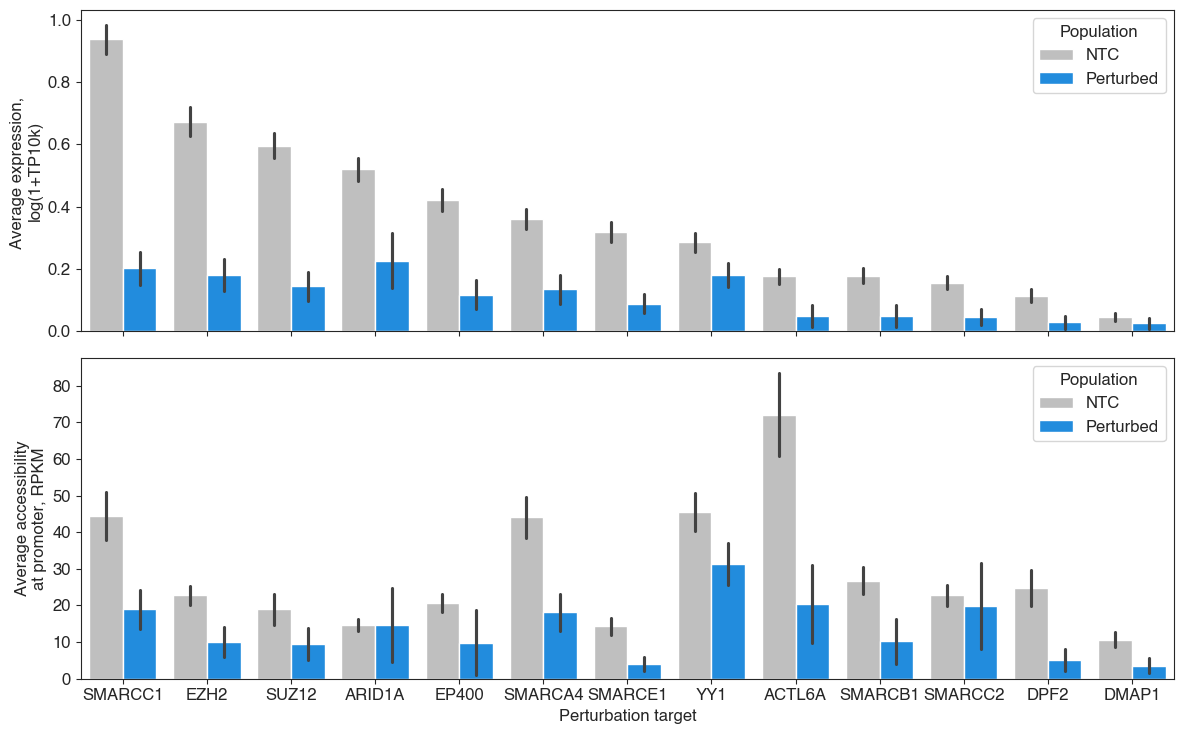

In [26]:
with sns.axes_style("ticks"):
    
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Helvetica']
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.unicode_minus'] = False
    # plt.rcdefaults()
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12,4), sharex = True)
    sns.barplot(data = df_plot_expr, x = 'Perturbation target', y = 'Average log(1+TP10k) expression', hue = 'Population', dodge = True, estimator = 'mean', errorbar = ('se', 1.96), order = ['SMARCC1', 'EZH2', 'SUZ12', 'ARID1A', 'EP400', 'SMARCA4', 'SMARCE1', 'YY1', 'ACTL6A', 'SMARCB1', 'SMARCC2', 'DPF2', 'DMAP1'], ax = ax[0], palette = sns.color_palette(['#bfbfbf', '#0390fc']))
    sns.barplot(data = df_ontarget_reads.reset_index(), x = 'Perturbation target', y = 'Average accessibility at promoter (RPKM)', hue = 'Population', dodge = True, estimator = 'mean', errorbar = ('se', 1.96), order = ['SMARCC1', 'EZH2', 'SUZ12', 'ARID1A', 'EP400', 'SMARCA4', 'SMARCE1', 'YY1', 'ACTL6A', 'SMARCB1', 'SMARCC2', 'DPF2', 'DMAP1'], ax = ax[1], palette = sns.color_palette(['#bfbfbf', '#0390fc']))
    ax[0].set_ylabel("Average expression, \nlog(1+TP10k)")
    ax[1].set_ylabel("Average accessibility\nat promoter, RPKM")
    plt.tight_layout()
    plt.savefig("outs/fig1d_knockdown_REVISED.pdf")
    plt.show()

### 1e) Z-score on-target knockdown

In [10]:
raw = sc.read_10x_h5("/data/norman/eli/T7/202404_SIRLOIN_multiome/Lane1_040/outs/filtered_feature_bc_matrix.h5")
raw.var_names_make_unique()
raw = raw[raw.obs.index.isin(singlets_040.index), ~raw.var_names.str.contains("MT-")]
raw.obs = raw.obs.join(singlets_040, how = 'right')

raw.obs['single_cell'] = True
raw.obs.rename({"guide_target":"guide_identity"}, axis = 1, inplace = True)

pop = CellPopulation(
    pd.DataFrame(raw.X.todense().A, index = raw.obs.index, columns = raw.var_names),
    raw.obs,
    raw.var,
    calculate_statistics = True
)
strip_low_expression(pop, threshold=0.05)
pop.normalized_matrix = normalize_to_gemgroup_control(pop, control_cells = "guide_identity == 'NTC'")

/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Generating summary statistics...
Done.
Normalizing all cells to 4869.5 UMI...
groupby: index in @key_barcodes and (guide_identity == 'NTC') (key = gem_group)
Processing gem group 1
     Determining scale factors...
     Normalizing matrix to median
Scaling with a small number of reads. Are you sure this is what you want?
     Normalizing control matrix to median
     Scaling matrix to control
     Done.
0.6785457134246826
Merging submatrices...


In [11]:
cellpop_normalized_sc = ad.AnnData(
    obs = pop.cells, 
    var = pop.genes.query('in_matrix'), 
    X = pop.where(normalized = True)
)
cellpop_normalized_sc

AnnData object with n_obs × n_vars = 4724 × 9992
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_guides', 'called', 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'guide_identity', 'single_cell', 'gem_group'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std', 'cv', 'fano', 'in_matrix'

In [12]:
dfS = requests.get("https://maayanlab.cloud/Harmonizome/api/1.0/gene_set/S+Phase/Reactome+Pathways").json()
dfG2M = requests.get("https://maayanlab.cloud/Harmonizome/api/1.0/gene_set/regulation+of+cell+cycle+G2%24slash%24M+phase+transition/GO+Biological+Process+Annotations+2023").json()
dfM = requests.get("https://maayanlab.cloud/Harmonizome/api/1.0/gene_set/M+Phase/Reactome+Pathways").json()

S_genes = [e['gene']['symbol'] for e in dfS['associations']]
G2M_genes = [e['gene']['symbol'] for e in dfG2M['associations']]
G2M_genes.extend([e['gene']['symbol'] for e in dfM['associations']])
G2M_genes = list(set(G2M_genes))

cellpop_regressed = cellpop_normalized_sc.copy()
sc.tl.score_genes_cell_cycle(cellpop_regressed, s_genes = S_genes, g2m_genes = G2M_genes)
sc.pp.regress_out(cellpop_regressed, keys = ['pct_counts_mito', 'S_score', 'G2M_score'])

... storing 'guide_identity' as categorical
... storing 'phase' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


In [13]:
cellpop_regressed_ps = CellPopulation(
            pd.DataFrame(cellpop_regressed.X, index=cellpop_regressed.obs.index, columns=cellpop_regressed.var.index), 
            cellpop_regressed.obs, 
            cellpop_regressed.var, 
            calculate_statistics=True
)
cellpop_regressed_ps.genes['gene_name'] = cellpop_regressed_ps.genes.index

Generating summary statistics...
Done.


In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    meanpop = cellpop_regressed_ps.average("guide_identity")

Computing average expression matrices...
Computing clusters...
Generating summary statistics...
Done.


In [20]:
guide_list = meanpop.cells.index.tolist()
guide_list.remove("NTC")
meanpop.genes["target"] = meanpop.genes.gene_name.map(lambda g: g in guide_list)
df = meanpop.where(genes = "target")
df_sorted = df.reindex(df.index, axis = 1).dropna(axis = 1)
df_sorted["in_col"] = df_sorted.index.isin(df_sorted.columns)
df_sorted = df_sorted.query("in_col").drop("in_col", axis = 1)
df_sorted

,ACTL6A,ARID1A,DMAP1,DPF2,EP400,EZH2,SMARCA4,SMARCB1,SMARCC1,SMARCC2,SMARCE1,SUZ12,YY1
ACTL6A,-0.209061,-0.043327,0.019027,-0.074501,0.022556,0.076631,-0.160755,0.020597,-0.124639,-0.072006,-0.099343,-0.059873,-0.016806
ARID1A,0.002540,-0.398579,-0.028307,0.026237,-0.053437,0.087003,0.257881,-0.034074,0.328340,0.261759,0.059016,-0.071693,-0.053391
DMAP1,-0.093012,-0.013295,-0.103055,0.032947,-0.034871,-0.014756,-0.065799,0.012972,-0.244679,-0.062041,-0.006057,-0.005373,-0.002357
DPF2,-0.013216,0.035516,-0.014859,-0.197083,-0.021273,-0.037295,-0.002885,-0.107389,0.042111,-0.031367,0.019661,-0.019991,-0.028972
EP400,-0.086882,-0.083554,0.060792,0.003633,-0.347686,-0.042944,-0.127384,0.181110,-0.253381,0.127838,0.151998,0.027708,0.114036
EZH2,0.039247,-0.015742,0.029263,-0.011673,0.087081,-0.467335,0.051070,0.020636,0.086664,0.069270,0.113836,0.039471,0.055402
SMARCA4,0.046847,0.003643,-0.036614,-0.065373,-0.067190,0.013510,-0.304409,0.002930,0.161094,0.078293,0.109568,0.053164,0.037024
SMARCB1,-0.067739,0.206835,-0.082310,-0.055604,0.055795,0.062554,0.118810,-0.249753,0.199835,0.063500,0.053045,-0.106487,0.164456
SMARCC1,0.153887,0.024033,-0.058544,-0.008787,0.014486,0.052170,0.028319,0.017549,-0.640889,-0.036326,0.019819,0.073102,0.069825
SMARCC2,-0.010019,-0.022029,0.097511,-0.021595,-0.007057,-0.036507,-0.052034,0.002759,0.002341,-0.242168,0.110573,-0.043813,0.025449


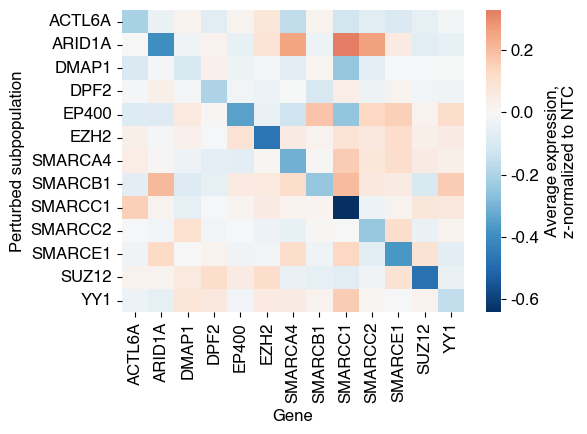

In [23]:
plt.figure(figsize = (6,4.5))
sns.heatmap(df_sorted, cmap = 'RdBu_r', center = 0, cbar_kws={"label": "Average expression,\nz-normalized to NTC"})
plt.xlabel("Gene")
plt.ylabel("Perturbed subpopulation")
plt.tight_layout()
plt.savefig("outs/fig1e_revised_label.pdf")
plt.show()

In [14]:
cellpop_regressed_ps.to_hdf("intermediate_files/gex_norm_regressed.hdf5")

Writing matrix...
Writing metadata...
! Converting categorical columns to string...
! Converting categorical columns to string...
Done in 3.5888619422912598s.


### 1f) Z-score promoter accessibility

In [27]:
# now get pseudobulk accessibility

mtx_norm = snap.tl.aggregate_X(mtx,groupby = 'guide_target', normalize = 'RPKM')
mtx_promoters = mtx_norm[:,mtx_norm.var.index.isin(promoter_intersection.index)].copy()
promoter_dict = dict(zip(promoter_intersection.index, promoter_intersection.gene_name))
mtx_promoters.var['gene_name'] = mtx_promoters.var.index.map(lambda s: promoter_dict.get(s, np.nan))
mtx_promoters.write("../intermediate_files/adata_040_singlets_promoter_tiles_RPKM.h5ad")

In [14]:
mtx_promoters = snap.read("../intermediate_files/adata_040_singlets_promoter_tiles_RPKM.h5ad", backed = None)
df_promoter_coverage = mtx_promoters.to_df().T
df_promoter_coverage = df_promoter_coverage.join(mtx_promoters.var)
df_promoter_total = df_promoter_coverage.groupby('gene_name').sum()
df_scaled = df_promoter_total.apply(lambda r: 100 * (r - r.NTC) / r.NTC, axis=1)
df_scaled

/tmp/ipykernel_742574/1717523191.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,ACTL6A,ARID1A,DMAP1,DPF2,EP400,EZH2,NTC,SMARCA4,SMARCB1,SMARCC1,SMARCC2,SMARCE1,SUZ12,YY1
gene_name,,,,,,,,,,,,,,
ACTL6A,-62.963547,1.397139,-10.835436,-26.720942,-11.065189,-1.803094,0.0,3.145284,0.861092,-25.476239,-16.525426,-15.975695,-17.189333,-11.147932
ARID1A,-5.958727,-18.231302,-9.631821,15.633218,-7.453738,-7.378562,0.0,11.377188,18.987447,-2.672861,15.170540,9.115148,-15.275993,20.949234
DMAP1,-6.136200,63.626242,-59.693913,2.009953,-1.256376,-4.307651,0.0,13.899002,14.167902,5.987057,9.417308,19.773325,0.192179,18.708327
DPF2,-32.568975,10.078228,-15.138236,-69.782260,5.131070,19.721947,0.0,-3.653949,23.340646,-15.220262,-7.394366,-11.965852,8.866827,-10.446996
EP400,-4.532774,19.482018,-1.636741,5.196277,-66.437578,-18.735126,0.0,-0.427943,3.126866,10.787659,2.487689,-0.389685,-5.907092,-1.329228
EZH2,-19.244336,14.111021,-16.476137,-16.467232,-1.025987,-51.114168,0.0,3.503206,-9.541707,-6.924855,-8.573041,-3.624854,-7.199176,-8.457147
SMARCA4,-10.960643,4.750985,3.884339,6.630783,15.171365,-0.451266,0.0,-45.942184,-1.001185,2.991681,13.436185,-8.622783,2.012249,1.810406
SMARCB1,17.476010,4.756819,-18.259745,15.316098,20.359479,-12.089496,0.0,-13.300809,-60.285604,7.575081,2.817035,1.583399,27.011298,-1.954889
SMARCC1,-17.268012,-8.223046,-9.988910,-11.406314,-9.096864,4.364654,0.0,7.348166,-3.004181,-52.152021,-9.427551,-7.806003,-16.981442,-4.446099


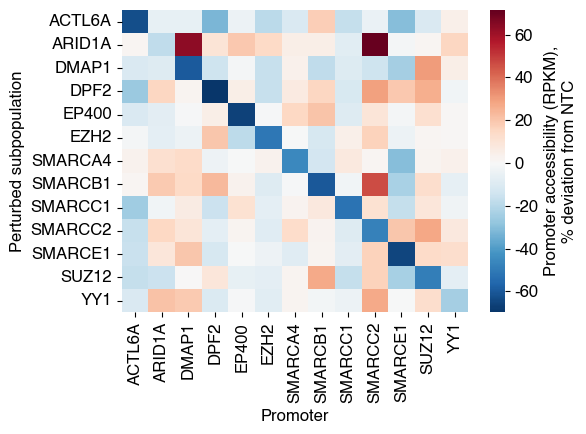

In [24]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize = (6,4.5))
sns.heatmap(df_scaled.drop("NTC", axis = 1).T, cmap = 'RdBu_r', center = 0, cbar_kws={"label": "Promoter accessibility (RPKM),\n% deviation from NTC"})
plt.xlabel("Promoter")
plt.ylabel("Perturbed subpopulation")
plt.tight_layout()
plt.savefig("outs/fig1f_revised_label.pdf")
plt.show()